In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import imread
from typing import List
from scripts.utils.traces_utils import load_traces, plot_traces_with_mean, calculate_df_traces, load_all_traces_for_plane, find_common_rois
from scripts.sample_db import SampleDB

In [2]:

# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)

# Load experiment
sample_id = '20220426_RM0008_130hpf_fP1_f3'
exp = sample_db.get_sample(sample_id)
print(exp.sample.id)

# Shortcuts for sample parameters
sample = exp.sample
raw_path = exp.paths["raw_path"]
anatomy_path = exp.paths["anatomy_path"]
em_path = exp.paths["em_path"]
n_planes = exp.params_lm.n_planes
n_frames = exp.params_lm.n_frames
n_slices = exp.params_lm.lm_stack_range
doubling = 2 if exp.params_lm.doubling else 1

# Get paths of the trial acquisitions
trial_paths = [os.path.splitext(path)[0] for path in os.listdir(os.path.join(raw_path, "trials"))]
print(trial_paths)


SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3'])
20220426_RM0008_130hpf_fP1_f3
['20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o2Ser_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o3Ctrl_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o4TCA_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o5GCA_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o6TDCA_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o7Cad_001_', '20220426_RM0008_130hpf_fP1_f3_t1_o8SA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o1Ala_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o2Ser_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o3Ctrl_002_', '20220426_RM0008_130hpf_fP1_f3_t2_o4TCA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o5GCA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o6TDCA_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o7Cad_001_', '20220426_RM0008_130hpf_fP1_f3_t2_o8SA_001_', '20220426_RM0008_130hpf_fP1_f3_t3_o1Ala_001_', '20220426_RM0008_130hpf_fP1_f3_t3_o2Ser_001_', '20220426_RM0008_130hpf_fP1_f3_t3_o3Ctrl_001_', '20220426_RM0008_1

In [6]:
#Load all raw traces from a plane
preprocessed_folder = os.path.join(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3", "preprocessed")
traces_folder = os.path.join(preprocessed_folder, "..", "traces") # TODO: add folders to sample

all_raw_traces = []

for plane in range(1):#range(n_planes*doubling): #### Change
    plane_str = f"{plane:02d}"
    for path in trial_paths:
        traces_file_path = os.path.join(traces_folder,f"traces_plane_{plane_str}_{path}.npy")
        traces = load_traces(traces_file_path).T
        all_raw_traces.append(traces)
        
print(len(all_raw_traces))
        

24


In [10]:
all_raw_traces[1]

,1,2,3,5,6,7,9,10,11,12,...,268,269,270,271,272,273,274,275,276,277
0,8145.613031,8146.564088,8145.673456,8135.899437,8131.156610,8142.960060,8134.519367,8130.699098,8140.953974,8149.334453,...,8128.320964,8127.472964,8124.395751,8126.073820,8125.891065,8124.793831,8125.901385,8125.558976,8125.522713,8125.394100
1,8153.637785,8146.512863,8141.527449,8138.665183,8129.393107,8153.221667,8153.987370,8135.706721,8145.399241,8132.827019,...,8137.215621,8128.416238,8126.107390,8125.197111,8126.047464,8126.164253,8128.840996,8129.324963,8126.556555,8126.505594
2,8126.682581,8126.572021,8126.762142,8126.661245,8126.057461,8126.554245,8126.267099,8126.532722,8126.932330,8126.211553,...,8128.032758,8125.718408,8127.061550,8126.491043,8126.277456,8126.416323,8126.224965,8126.205522,8125.696560,8125.292930
3,8127.444574,8126.701286,8126.833596,8126.904446,8127.207996,8127.550616,8126.547437,8127.410681,8126.617704,8126.477537,...,8125.540908,8125.900167,8125.180488,8125.590510,8125.367864,8125.485026,8125.724374,8126.554142,8126.039516,8124.376270
4,8125.872206,8126.066890,8125.887479,8126.618303,8126.822871,8126.424665,8126.031542,8126.052738,8127.469681,8126.309076,...,8126.856287,8126.897412,8125.404586,8126.128894,8126.465716,8126.585766,8127.404096,8126.001858,8124.625110,8122.546232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,8139.752370,8144.010009,8138.175996,8130.854991,8131.354980,8138.472944,8131.231490,8132.271387,8141.434923,8140.285211,...,8127.972590,8127.684228,8125.679413,8125.880757,8128.048564,8128.486196,8126.419909,8125.932876,8130.874781,8134.523401
371,8132.202693,8141.236150,8136.253234,8137.687277,8137.383424,8141.615560,8139.207257,8130.685759,8151.061213,8135.950834,...,8129.505296,8124.886938,8132.259810,8125.209981,8125.758974,8126.245877,8126.311102,8126.038742,8132.149432,8136.138033
372,8145.449443,8149.073606,8141.487887,8135.638477,8131.448119,8137.726706,8130.584219,8129.971611,8143.971203,8138.911715,...,8130.910500,8125.660529,8124.993194,8125.387222,8127.456951,8128.928883,8128.798967,8125.667671,8129.594275,8128.404074
373,8159.991112,8146.417063,8149.081434,8135.754407,8132.567755,8139.079211,8141.978492,8131.595276,8138.739356,8135.019942,...,8125.383095,8131.778582,8125.554907,8125.796613,8127.998349,8124.800898,8131.305792,8127.658410,8129.539147,8131.618315


(301, 375)


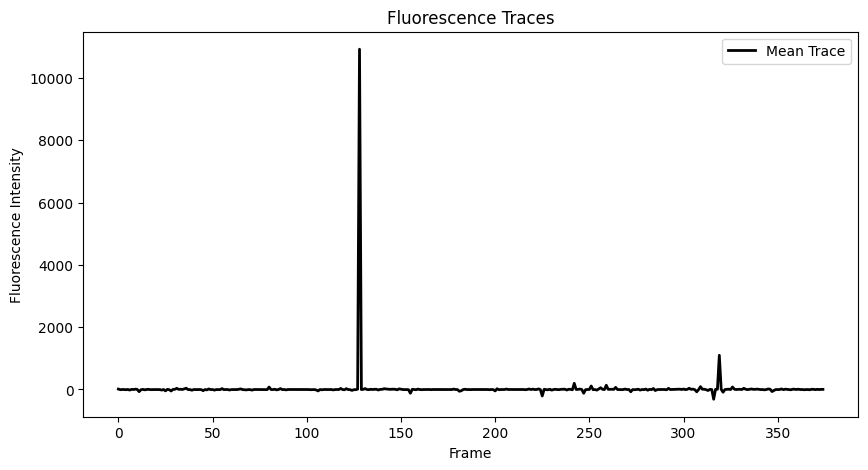

In [21]:
# Calculate df traces

# Define baseline frames (example: frames 80 to 100)
baseline_frames = list(range(80, 100))
motor_frames = list(range(15, 30))
# Calculate ΔF/F traces
df_traces = calculate_df_traces(raw_traces, baseline_frames, motor_frames)
print(df_traces.shape)

# Plot ΔF/F traces with their mean
plot_traces_with_mean(df_traces)


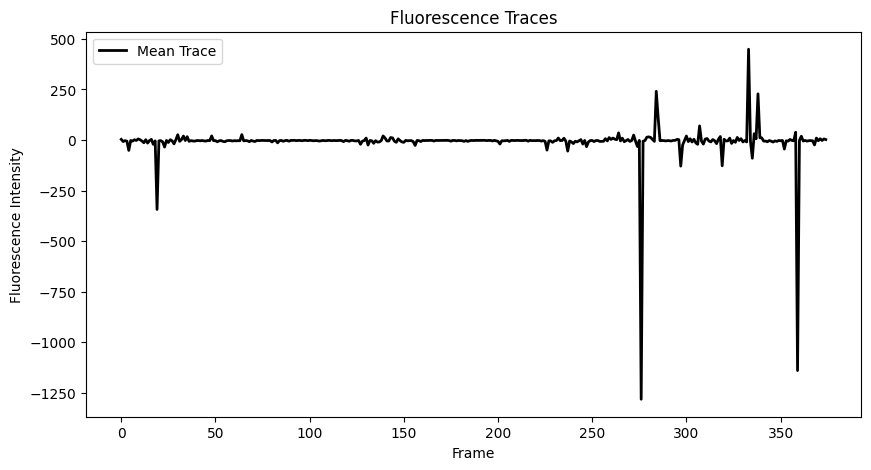

In [10]:
traces = df_traces
plt.figure(figsize=(10, 5))
for trace in traces:
    plt.plot(trace, alpha=0.5)

mean_traces = np.mean(traces, axis=0)
plt.plot(mean_traces, color='black', linewidth=2, label='Mean Trace')
plt.legend()
plt.title('Fluorescence Traces')
plt.xlabel('Frame')
plt.ylabel('Fluorescence Intensity')
plt.show()

In [ ]:
def load_all_traces_for_plane(traces_folder: str, plane_str: str) -> List[pd.DataFrame]:
    """
    Load all traces for a specific plane from all trials.
    
    Parameters:
    traces_folder (str): Path to the folder containing fluorescence data.
    plane_str (str): String identifier for the plane.
    
    Returns:
    List[pd.DataFrame]: List of DataFrames containing fluorescence traces for each trial.
    """
    all_traces = []
    for file in os.listdir(traces_folder):
        if file.endswith(".npy") and f"traces_plane_{plane_str}" in file:
            traces_df = load_traces(os.path.join(traces_folder, file), as_df=True)
            all_traces.append(traces_df)
    return all_traces

def find_common_rois(all_traces: List[pd.DataFrame]) -> List[str]:
    """
    Find ROIs that are common across all trials.
    
    Parameters:
    all_traces (List[pd.DataFrame]): List of DataFrames containing fluorescence traces for each trial.
    
    Returns:
    List[str]: List of common ROI identifiers.
    """
    common_rois = set(all_traces[0].columns)
    for traces_df in all_traces[1:]:
        common_rois.intersection_update(traces_df.columns)
    return list(common_rois)

# Example usage
traces_folder = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\traces'
plane_str = "03"

# Load all traces for the specified plane
all_traces = load_all_traces_for_plane(traces_folder, plane_str)

# Find common ROIs
common_rois = find_common_rois(all_traces)
print(f"Common ROIs: {common_rois}")

# Extract and plot traces for common ROIs
if common_rois:
    common_traces = [df[common_rois] for df in all_traces]
    for i, traces_df in enumerate(common_traces):
        baseline_frames = list(range(80, 100))
        noise_frames = (0, 6)
        df_traces = calculate_dFoverF_traces(traces_df, baseline_frames, noise_frames)
        print(f"Plotting trial {i+1}")
        plot_traces_with_mean(df_traces.values)
else:
    print("No common ROIs found across all trials.")

In [9]:
np.mean(raw_traces[range(0,30)], axis=0)

0     8123.766410
1     8123.796425
2     8123.700489
3     8123.553650
4     8123.505886
5     8123.769263
6     8123.512396
7     8123.688542
8     8124.049143
9     8123.739347
10    8123.607501
11    8123.849586
12    8123.559082
13    8123.693264
14    8123.880505
15    8123.779866
16    8123.802730
17    8124.164999
18    8124.112818
19    8123.987894
20    8123.695614
21    8123.698885
22    8123.736390
23    8123.919731
24    8124.109948
25    8123.697622
26    8123.793747
27    8123.926464
28    8123.779658
29    8123.755742
dtype: float64

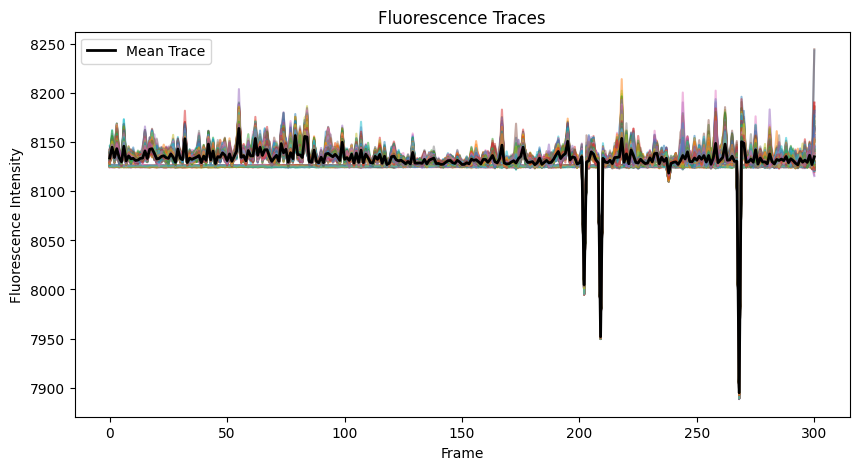

In [4]:
plot_traces_with_mean(raw_traces.values)

In [4]:


def save_dff_data(dff_data: dict, output_folder: str):
    """
    Save ΔF/F data to the specified folder.
    
    Parameters:
    dff_data (dict): Dictionary containing ΔF/F data.
    output_folder (str): Path to the folder to save ΔF/F data files.
    """
    for key, value in dff_data.items():
        np.save(os.path.join(output_folder, f"dff_{key}.npy"), value)
        for roi, dff_values in value.items():
            df = pd.DataFrame(dff_values, columns=[f'ROI_{roi}'])
            df.to_csv(os.path.join(output_folder, f"{key}_ROI_{roi}_dff.csv"), index_label='Frame')
            
            
# Example of loading and plotting ΔF/F data
def plot_dff_data(dff_file_path):
    trial_dff = np.load(dff_file_path, allow_pickle=True).item()
    np_dff_traces = np.array(list(trial_dff.values()))
    
    plt.figure(figsize=(10, 5))
    for trace in np_dff_traces:
        plt.plot(trace, alpha=0.5)
    
    mean_dff_traces = np.mean(np_dff_traces, axis=0)
    plt.plot(mean_dff_traces, color='black', linewidth=2, label='Mean ΔF/F Trace')
    plt.legend()
    plt.title('ΔF/F Traces')
    plt.xlabel('Frame')
    plt.ylabel('ΔF/F')
    plt.show()

# Define the paths
traces_folder = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\traces'
output_folder = os.path.join(traces_folder, "df")
os.makedirs(output_folder, exist_ok=True)






In [5]:

# Define baseline frames (example: first 50 frames)
baseline_frames = list(range(50,100))

# Load fluorescence data
fluorescence_data = load_fluorescence_data(traces_folder, plane_nr=00)
print(fluorescence_data)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:

# Calculate ΔF/F for each plane and trial
dff_data = {}
for key, trial_fluorescence in fluorescence_data.items():
    trial_dff = {}
    for roi, fluorescence_values in trial_fluorescence.items():
        trial_dff[roi] = calculate_dff(fluorescence_values, baseline_frames)
    dff_data[key] = trial_dff

# Save ΔF/F data
save_dff_data(dff_data, output_folder)

print("ΔF/F traces calculated and saved.")



# Example path to a ΔF/F data file
dff_file_path = os.path.join(output_folder, "dff_plane_03_20220426_RM0008_130hpf_fP1_f3_t1_o6TDCA_001.npy")
plot_dff_data(dff_file_path)


In [124]:

from scripts.utils.traces_utils import *


# Example usage
traces_folder = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\traces'
plane_str = "03"
baseline_frames = list(range(80, 100))
motor_frames = list(range(15, 30))
shutter_off_trials = [0, 1]  # Specify the trials where the shutter was off



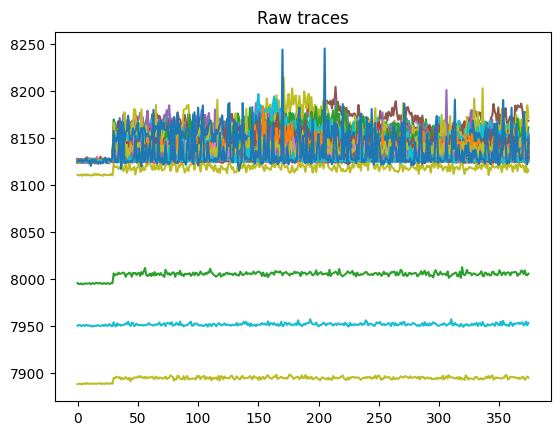

In [82]:
# Get raw traces
traces_file_path = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\..\masks\traces\traces_plane_03_20220426_RM0008_130hpf_fP1_f3_t3_o4TCA_001_.npy"
raw_traces = load_traces(traces_file_path)
raw_traces.plot().set_title('Raw traces')
plt.legend().set_visible(False)

In [83]:
raw_traces.shape

(375, 301)

In [94]:
# Calculate dF traces
baseline_frames = list(range(80, 100))
shutter_off_frames = list(range(0, 30))
df_traces = calculate_df_traces(raw_traces, baseline_frames, shutter_off_frames)
print(df_traces.shape)

(301,)
(301,)
(375, 301)


In [97]:
df_traces.tail()

,731,734,739,742,743,748,749,750,751,752,...,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629
370,-0.086572,0.081807,-0.389434,-0.371909,-0.164327,0.170424,0.106085,0.127098,0.306366,-0.133594,...,-0.056793,-0.883033,7.099938,0.124674,0.183216,-0.627375,-0.636746,-0.128629,-0.674873,2.964377
371,-0.171386,0.187864,0.024165,-0.373078,0.137268,1.070820,-0.020627,-0.101709,0.435488,0.538670,...,0.913736,-0.752205,-1.386119,-0.149228,-0.830784,-0.384307,-0.588917,0.034206,-1.590165,1.159042
372,-0.311689,-0.096179,0.454995,-0.435006,0.014442,-0.249875,0.217619,0.148468,0.114401,-0.543614,...,0.335358,-0.325668,-2.707999,-0.140853,0.986799,0.813823,-1.059242,-0.466232,-1.077690,-0.867954
373,-0.510110,-0.048211,0.231232,-0.305546,0.198969,-0.084511,0.162193,-0.382344,0.262388,0.084168,...,-0.571505,0.494003,-2.478324,0.227987,-0.039826,-1.041006,-0.135776,0.555969,0.485084,-1.271947
374,0.238341,0.246443,0.004790,-0.511640,0.808558,0.200753,0.462165,-0.333083,0.240346,0.368178,...,0.091029,-0.425793,6.466587,0.015416,-0.413512,-0.891020,1.115351,0.471789,-1.082509,0.568974


C:\Users\montruth\AppData\Local\Temp\ipykernel_11396\567351988.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


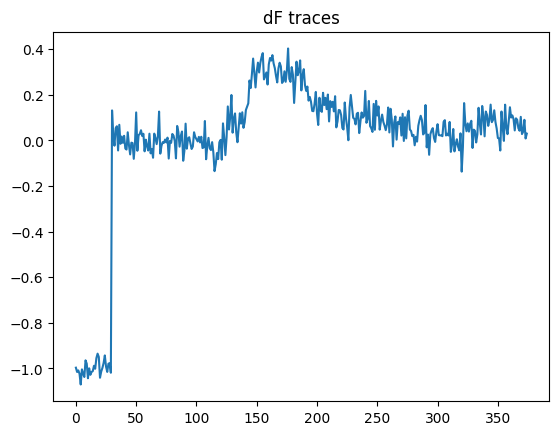

In [127]:
df_traces.T.mean().plot().set_title('dF traces')
plt.legend().set_visible(False)
plt.show()


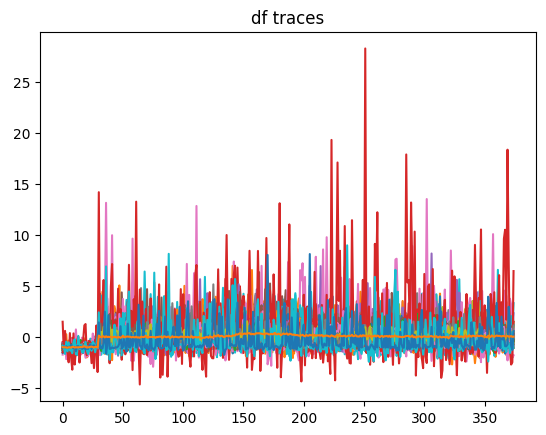

In [106]:
df_traces.plot().set_title('df traces')


df_traces.mean("columns").plot()
plt.legend().set_visible(False)

In [123]:
# Load all trials
def find_common_index(all_traces: List[pd.DataFrame]) -> pd.Index:
    """
    Find common indices across all DataFrames.
    
    Parameters:
    all_traces (List[pd.DataFrame]): List of DataFrames containing fluorescence traces for each trial.
    
    Returns:
    pd.Index: Common index for all DataFrames.
    """

    common_index = all_traces[0].T.index
    print(common_index)
    for traces_df in all_traces[1:]:
        print('traces_df')
        print(traces_df.shape)
        common_index = common_index.intersection(traces_df.T.index)
    return common_index

def stack_dataframes(all_traces: List[pd.DataFrame], common_index: pd.Index) -> pd.DataFrame:
    """
    Stack DataFrames with a MultiIndex.
    
    Parameters:
    all_traces (List[pd.DataFrame]): List of DataFrames containing fluorescence traces for each trial.
    common_index (pd.Index): Common index for all DataFrames.
    
    Returns:
    pd.DataFrame: Stacked DataFrame with MultiIndex.
    """
    stacked_df = pd.concat([df.loc[common_index] for df in all_traces], keys=range(len(all_traces)), names=['trial', 'roi'])
    return stacked_df

# Example usage
traces_folder = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\traces'
plane_str = "01"

# Load all traces for the specified plane
all_traces = []
for file in os.listdir(traces_folder):
    if file.endswith(".npy") and f"traces_plane_{plane_str}" in file:
        traces_df = load_traces(os.path.join(traces_folder, file))
        all_traces.append(traces_df)

print(len(all_traces))
# Find common index
common_index = find_common_index(all_traces)
print(f"Common Index: {common_index}")

# Stack DataFrames with MultiIndex
stacked_df = stack_dataframes(all_traces, common_index)
print(stacked_df)

# Example of accessing data
print(stacked_df.loc[0].head())  # Access data for the first trial
print(stacked_df.loc[(0, common_index[0])])  

24
Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237],
      dtype='uint16', length=237)
traces_df
(375, 249)
traces_df
(375, 261)
traces_df
(375, 261)
traces_df
(375, 256)
traces_df
(375, 257)
traces_df
(375, 271)
traces_df
(375, 246)
traces_df
(375, 247)
traces_df
(375, 3)
traces_df
(375, 305)
traces_df
(375, 294)
traces_df
(375, 250)
traces_df
(375, 250)
traces_df
(375, 254)
traces_df
(375, 245)
traces_df
(375, 257)
traces_df
(375, 234)
traces_df
(375, 260)
traces_df
(375, 257)
traces_df
(375, 266)
traces_df
(375, 257)
traces_df
(375, 253)
traces_df
(375, 252)
Common Index: Index([], dtype='uint16')
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,

KeyError: 0

In [5]:
import os
import numpy as np
import pandas as pd
from typing import List

def load_traces(traces_file_path: str, as_df: bool = False) -> pd.DataFrame:
    """
    Load fluorescence traces from a .npy file.
    
    Parameters:
    traces_file_path (str): Path to the .npy file containing fluorescence traces.
    as_df (bool): Return the traces as a DataFrame if True, otherwise as a dictionary.
    
    Returns:
    dict or pd.DataFrame: Fluorescence traces.
    """
    traces_dict = {id: trace for id, trace in np.load(traces_file_path, allow_pickle=True).item().items()}
    traces_df = pd.DataFrame.from_dict(traces_dict, orient='index')
    return traces_df if as_df else traces_dict

def find_common_index(all_traces: List[pd.DataFrame]) -> pd.Index:
    """
    Find common indices across all DataFrames.
    
    Parameters:
    all_traces (List[pd.DataFrame]): List of DataFrames containing fluorescence traces for each trial.
    
    Returns:
    pd.Index: Common index for all DataFrames.
    """
    common_index = all_traces[0].index
    for traces_df in all_traces[1:]:
        common_index = common_index.intersection(traces_df.index)
    return common_index

def filter_dataframes(all_traces: List[pd.DataFrame], common_index: pd.Index) -> List[pd.DataFrame]:
    """
    Filter DataFrames to only include rows with the common indices.
    
    Parameters:
    all_traces (List[pd.DataFrame]): List of DataFrames containing fluorescence traces for each trial.
    common_index (pd.Index): Common index for all DataFrames.
    
    Returns:
    List[pd.DataFrame]: List of filtered DataFrames.
    """
    filtered_traces = [df.loc[common_index] for df in all_traces]
    return filtered_traces

def stack_dataframes(filtered_traces: List[pd.DataFrame]) -> pd.DataFrame:
    """
    Stack DataFrames with a MultiIndex.
    
    Parameters:
    filtered_traces (List[pd.DataFrame]): List of filtered DataFrames containing fluorescence traces for each trial.
    
    Returns:
    pd.DataFrame: Stacked DataFrame with MultiIndex.
    """
    stacked_df = pd.concat(filtered_traces, keys=range(len(filtered_traces)), names=['trial', 'roi'])
    return stacked_df

# Example usage
traces_folder = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\traces'
plane_str = "00"

# Load all traces for the specified plane
all_traces = []
for file in os.listdir(traces_folder):
    if file.endswith(".npy") and f"traces_plane_{plane_str}" in file:
        traces_df = load_traces(os.path.join(traces_folder, file), as_df=True)
        all_traces.append(traces_df)

# Find common index
common_index = find_common_index(all_traces)
print(f"Common Index: {common_index}")

# Filter DataFrames to only include rows with the common indices
filtered_traces = filter_dataframes(all_traces, common_index)

# Stack DataFrames with MultiIndex
stacked_df = stack_dataframes(filtered_traces)
print(stacked_df)

# Example of accessing data
print(stacked_df.loc[0].head())  # Access data for the first trial
print(stacked_df.loc[(0, common_index[0])])  # Access data for the first trial and the first common ROI



Common Index: Index([ 10,  12,  15,  19,  20,  23,  25,  29,  34,  35,  38,  41,  42,  43,
        44,  46,  48,  50,  52,  53,  56,  57,  61,  63,  65,  66,  67,  68,
        71,  72,  73,  75,  76,  79,  80,  83,  85,  86,  87,  88,  90,  92,
        93,  95,  97,  98, 101, 103, 106, 109, 110, 111, 113, 115, 118, 123,
       129, 130, 131, 133, 134, 135, 141, 143, 144, 148, 153, 156, 159, 160,
       163, 165, 166, 168, 170, 171, 172, 173, 174, 175, 177, 180, 181, 184,
       187, 188, 192, 196, 197, 198, 199, 201, 203, 204, 208, 212, 213, 215,
       222, 225],
      dtype='uint16')
                   0            1            2            3            4    \
trial roi                                                                    
0     10   8149.700787  8127.000000  8126.527559  8127.409449  8127.330709   
      12   8149.358108  8126.979730  8127.087838  8127.168919  8127.533784   
      15   8146.888000  8127.208000  8126.568000  8127.656000  8127.040000   
      19   8149.5

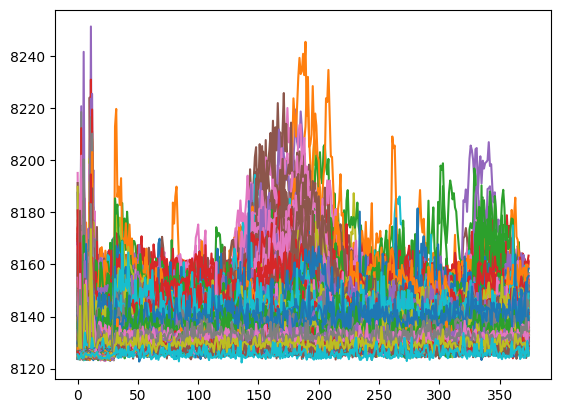

In [13]:
stacked_df.T.plot()
plt.legend().set_visible(False)

C:\Users\montruth\AppData\Local\Temp\ipykernel_4932\3238467815.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


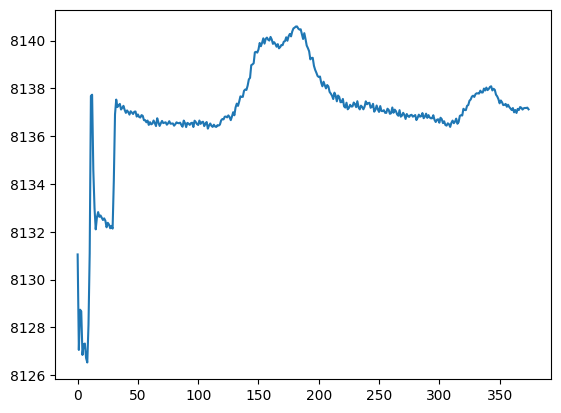

In [14]:
stacked_df.T.mean(axis=1).plot()
plt.legend().set_visible(False)

In [27]:
# Calculate df traces
# Calculate dF traces
baseline_frames = list(range(50, 100))
shutter_off_frames = list(range(0, 30))
df_traces = calculate_df_traces(stacked_df.T, baseline_frames, shutter_off_frames)
print(df_traces.shape)

(2400,)
(2400,)
(375, 2400)


In [26]:
stacked_df.T.shape

(375, 2400)

(-1.0, 1.0)

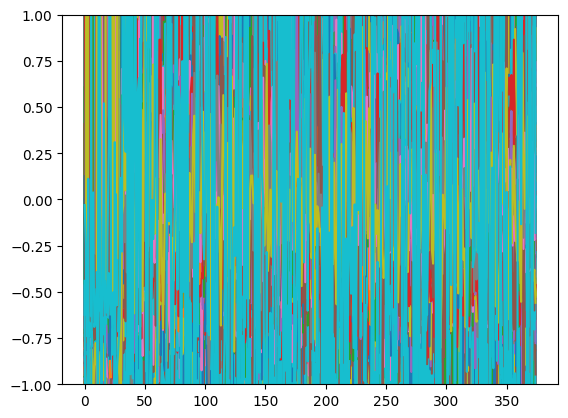

In [28]:
df_traces.plot()
plt.legend().set_visible(False)
plt.ylim((-1,1))

(375,)


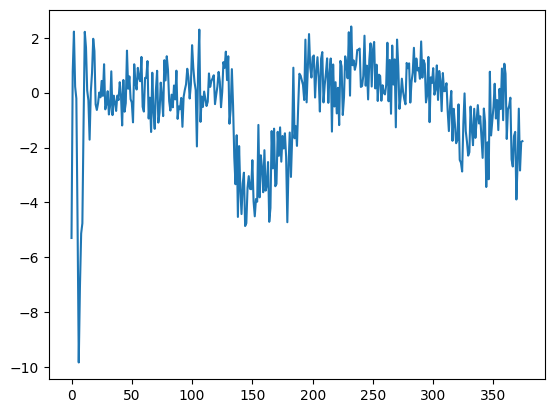

In [30]:
df_traces.T.mean(axis=0).plot()
print(df_traces.T.mean(axis=0).shape)